In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np
from time import time

from numba import jit, float32, vectorize, guvectorize
import math


In [2]:
!nvidia-smi

Sun Nov 13 08:09:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 522.30       Driver Version: 522.30       CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   33C    P0    28W /  N/A |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

imporing mnist

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = (x_train/256-0.5).astype('float32') 
x_test = (x_test/256-0.5).astype('float32') 

In [4]:
x_train = x_train[:60000]
x_test = x_test[:60000]

In [5]:
SIZE = 28


PATCH_SIZE = 7

patch_per_edge = int(SIZE/PATCH_SIZE)

In [6]:
patch_per_edge

4

## testing the patch creation agorithm

In [34]:
def patch_creation(image):
    '''this function takes an image of shape (SIZE,SIZE) and returns a tensor of the form: ((PATCH_SIZE/SIZE)^2, PATCH_SIZE^2) where the fist 
       index is the number of patches and the second is the patch size'''
    out = list()

    for i in range(patch_per_edge):
        for j in range(patch_per_edge):
            out.append(image[i*PATCH_SIZE:i*PATCH_SIZE+PATCH_SIZE, j*PATCH_SIZE:j*PATCH_SIZE+PATCH_SIZE])
    return np.array(out)



In [35]:
# testing the performache of the patch creation function:

times_standard = []
for i in range(100):
    t = time()
    image_patched = list()
    for im in list(x_train):
        image_patched.append(patch_creation(im))
    times_standard.append(time()-t)



In [36]:
times_standard

[0.6861536502838135,
 0.6631486415863037,
 0.6741502285003662,
 0.66914963722229,
 0.6591472625732422,
 0.6681489944458008,
 0.6631486415863037,
 0.6541457176208496,
 0.6641485691070557,
 0.6551461219787598,
 0.658146858215332,
 0.6601474285125732,
 0.6621482372283936,
 0.6541461944580078,
 0.6511454582214355,
 0.6591472625732422,
 0.6561462879180908,
 0.657146692276001,
 0.6691498756408691,
 0.663149356842041,
 0.6691482067108154,
 0.6711511611938477,
 0.6741495132446289,
 0.6611473560333252,
 0.6541461944580078,
 0.6731517314910889,
 0.6541447639465332,
 0.6541461944580078,
 0.6601474285125732,
 0.6631481647491455,
 0.6601476669311523,
 0.6851527690887451,
 0.6591472625732422,
 0.6521463394165039,
 0.660146951675415,
 0.6571471691131592,
 0.657146692276001,
 0.6591470241546631,
 0.6531460285186768,
 0.6551463603973389,
 0.6521453857421875,
 0.656146764755249,
 0.6521458625793457,
 0.6521453857421875,
 0.6571474075317383,
 0.6551461219787598,
 0.6531462669372559,
 0.6541459560394287,


since this performace are not satifactory (this function has to be used many times in the tranining loop) we will do some work to optimizte it

In [37]:
#import numba and use jit!

@jit(nopython=True)
def patch_creation_jit(image):
    '''this function takes an image of shape (SIZE,SIZE) and returns a tensor of the form: ((PATCH_SIZE/SIZE)^2, PATCH_SIZE^2)'''
    
    out = np.zeros(shape=(patch_per_edge**2, PATCH_SIZE**2))
    c=0
    for i in range(patch_per_edge):
        for j in range(patch_per_edge):
            # we need to use the ascontiguousarray function in order to be able to reshape the array in numba
            out[c,:] = np.ascontiguousarray(image[i*PATCH_SIZE:i*PATCH_SIZE+PATCH_SIZE, j*PATCH_SIZE:j*PATCH_SIZE+PATCH_SIZE]).reshape(PATCH_SIZE**2)
            c+=1

    return out

In [38]:
# testing the performache of the patch creation function:
# the first test will not be significative so we must rerun this cell
times_jited = []
for i in range(100):
    t = time()
    image_patched = list()
    for im in list(x_train):
        image_patched.append(patch_creation_jit(im))
    times_jited.append(time()-t)

times_jited

[0.5371198654174805,
 0.3290736675262451,
 0.33507490158081055,
 0.3410758972167969,
 0.32607293128967285,
 0.33307433128356934,
 0.33307456970214844,
 0.3250718116760254,
 0.32607340812683105,
 0.33007359504699707,
 0.3250725269317627,
 0.31907129287719727,
 0.3450770378112793,
 0.3250727653503418,
 0.3210713863372803,
 0.329073429107666,
 0.3340749740600586,
 0.3200714588165283,
 0.33507561683654785,
 0.33507418632507324,
 0.3180708885192871,
 0.327073335647583,
 0.32607269287109375,
 0.32407212257385254,
 0.32807374000549316,
 0.3360748291015625,
 0.3230721950531006,
 0.3340740203857422,
 0.3290743827819824,
 0.318070650100708,
 0.3340747356414795,
 0.33307409286499023,
 0.3210721015930176,
 0.3290736675262451,
 0.33707499504089355,
 0.31907153129577637,
 0.3270730972290039,
 0.33907580375671387,
 0.3230719566345215,
 0.3300740718841553,
 0.3320739269256592,
 0.32407236099243164,
 0.32807302474975586,
 0.33507490158081055,
 0.327073335647583,
 0.33307433128356934,
 0.333074569702148

as we can see jiting the function is better but this is still not satisfactory! let's take out the big guns and use the generalized universal vectorization

In [39]:
@guvectorize([(float32[:,:,:], float32[:,:,:], float32[:,:,:])],
             "(m, n, n), (m, q, p)->(m, q, p)", nopython=True)       
# note the trick used to ouput a matrix with dimensions q and p, that never appear in the input!
# this is probably just a limitation of numba
# also note the fact that guvectorize does not have a return! the output arguments has to be the last input! 
def patch_creation_vec(images, out, out_1):
    '''this function takes a tensor of images of shape (-1, SIZE, SIZE) and returns a tensor of the form: (-1, (PATCH_SIZE/SIZE)^2, PATCH_SIZE^2)
     where the 9 is the number of patch and the 36 are the patch features.
     This function is guvectorized and needs to recive the output variable as input 
     (2 times, this is needed to output a custom different shape)'''

    for m in range(images.shape[0]):
        c=0
        for i in range(patch_per_edge):
            for j in range(patch_per_edge):
                # we need to use the ascontiguousarray function in order to be able to reshape the array in numba
                out[m, c,:] = np.ascontiguousarray(images[m, i*PATCH_SIZE:i*PATCH_SIZE+PATCH_SIZE, j*PATCH_SIZE:j*PATCH_SIZE+PATCH_SIZE]).reshape(PATCH_SIZE**2)#+1/(c+1)
                c+=1 

In [40]:
times_guvectorize = []
test_vec = x_train[:60000].astype('float32')
# we define a single output vector for each trial because we do not care about the numbers just the time 
out = np.zeros(shape=(60000, 16,49))
out = np.zeros(shape=(60000, 16,49)).astype('float32')
for i in range(100):
    t = time()     
    output = patch_creation_vec(test_vec, out, out) # we need to pass out 2 times because of the above mentioned trick
    times_guvectorize.append(time()-t)
times_guvectorize

[0.21004724502563477,
 0.19904470443725586,
 0.20304536819458008,
 0.20304512977600098,
 0.19104290008544922,
 0.19404315948486328,
 0.20104503631591797,
 0.20104503631591797,
 0.2000446319580078,
 0.19504332542419434,
 0.19204282760620117,
 0.19704413414001465,
 0.20204544067382812,
 0.21004605293273926,
 0.1980445384979248,
 0.19304323196411133,
 0.19504356384277344,
 0.20204544067382812,
 0.2070457935333252,
 0.1890420913696289,
 0.19104313850402832,
 0.19004225730895996,
 0.1960437297821045,
 0.20404553413391113,
 0.19704556465148926,
 0.19404220581054688,
 0.19304275512695312,
 0.20104503631591797,
 0.2050457000732422,
 0.19704413414001465,
 0.19104266166687012,
 0.19204282760620117,
 0.19904422760009766,
 0.2050468921661377,
 0.21004605293273926,
 0.19704413414001465,
 0.19404315948486328,
 0.19904446601867676,
 0.20404553413391113,
 0.1980443000793457,
 0.19004249572753906,
 0.19104266166687012,
 0.19704389572143555,
 0.20104455947875977,
 0.19904541969299316,
 0.192042589187622

In [41]:
#import numba and use jit!

@jit(nopython=True)
def patch_creation_jit_full_dataset(images):
    '''this function takes an image of shape (SIZE,SIZE) and returns a tensor of the form: ((PATCH_SIZE/SIZE)^2, PATCH_SIZE^2)'''
    image_patched = list()
    for im in list(images):
        
        out = np.zeros(shape=(patch_per_edge**2, PATCH_SIZE**2))
        c=0
        for i in range(patch_per_edge):
            for j in range(patch_per_edge):
                # we need to use the ascontiguousarray function in order to be able to reshape the array in numba
                out[c,:] = np.ascontiguousarray(im[i*PATCH_SIZE:i*PATCH_SIZE+PATCH_SIZE, j*PATCH_SIZE:j*PATCH_SIZE+PATCH_SIZE]).reshape(PATCH_SIZE**2)
                c+=1
    image_patched.append(patch_creation_jit(im))
    return out



In [42]:
times_jited_full_dataset = []
for i in range(100):
    t = time()
    patch_creation_jit_full_dataset(x_train)
    times_jited_full_dataset.append(time()-t)

times_jited_full_dataset

[0.7031571865081787,
 0.14203143119812012,
 0.14103174209594727,
 0.14141249656677246,
 0.14203166961669922,
 0.14103126525878906,
 0.14103174209594727,
 0.14203166961669922,
 0.14203166961669922,
 0.14403223991394043,
 0.14103150367736816,
 0.14103174209594727,
 0.14403200149536133,
 0.14203166961669922,
 0.14103150367736816,
 0.14103150367736816,
 0.14303183555603027,
 0.14103174209594727,
 0.14103126525878906,
 0.14203190803527832,
 0.14103150367736816,
 0.14103174209594727,
 0.14103150367736816,
 0.14103126525878906,
 0.14303207397460938,
 0.14103102684020996,
 0.14103174209594727,
 0.14603352546691895,
 0.14103055000305176,
 0.14203143119812012,
 0.14103198051452637,
 0.14103126525878906,
 0.14303207397460938,
 0.14103150367736816,
 0.14103174209594727,
 0.14103102684020996,
 0.14103174209594727,
 0.14103174209594727,
 0.14103126525878906,
 0.14103150367736816,
 0.14203166961669922,
 0.14203190803527832,
 0.14303231239318848,
 0.14203095436096191,
 0.14103198051452637,
 0.14203190

In [43]:
import pandas as pd
import seaborn as sns


In [48]:
df = pd.DataFrame()
df['guvectorize'] = times_guvectorize
df['jited'] = times_jited
df['standard'] = times_standard
df['jited_full_dataset'] = times_jited_full_dataset


In [49]:
df

,guvectorize,jited,standard,jited_full_dataset
0,0.210047,0.537120,0.686154,0.703157
1,0.199045,0.329074,0.663149,0.142031
2,0.203045,0.335075,0.674150,0.141032
3,0.203045,0.341076,0.669150,0.141412
4,0.191043,0.326073,0.659147,0.142032
...,...,...,...,...
95,0.190042,0.331074,0.658147,0.143032
96,0.189043,0.321072,0.669150,0.143032
97,0.196043,0.340075,0.664148,0.142031
98,0.200045,0.329073,0.665148,0.143032


Text(0, 0.5, 'seconds for 60000 images')

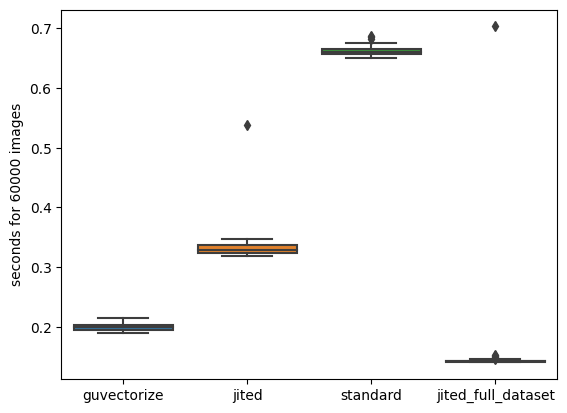

In [50]:
sns.boxplot(data=df  )
plt.ylabel("seconds for 60000 images")

Text(0, 0.5, 'seconds for 60000 images')

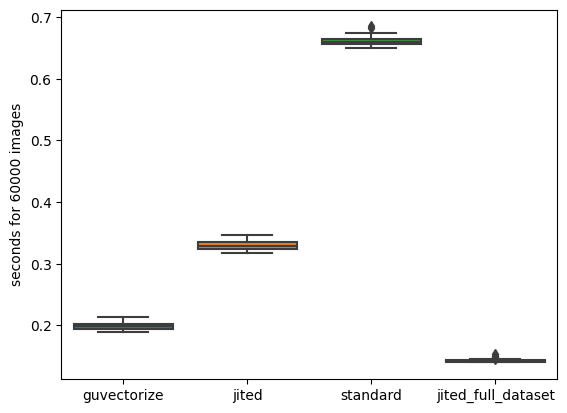

In [51]:
# removing the first jited iteration:

df = pd.DataFrame()
df['guvectorize'] = times_guvectorize[1:]
df['jited'] = times_jited[1:]
df['standard'] = times_standard[1:]
df['jited_full_dataset'] = times_jited_full_dataset[1:]

sns.boxplot(data=df  )
plt.ylabel("seconds for 60000 images")

In [52]:
# images per seconds
60000/df.describe().loc['mean']

guvectorize           302145.666981
jited                 181749.751298
standard               90677.578437
jited_full_dataset    421709.455628
Name: mean, dtype: float64